In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [11]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [13]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.iloc[[0, 1, 2, 1460, -3, -2, -1], [0, 1, 2, 3, -3, -2, -1]]
all_features.shape

(2919, 79)

In [14]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()), axis = 0
)

all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [17]:
n = train_data.shape[0]
train_features = torch.tensor(all_features[:n].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:, -1].values, dtype=torch.float32).reshape(-1, 1) 
train_features.shape, test_features.shape, train_labels.shape

(torch.Size([1460, 331]), torch.Size([1459, 331]), torch.Size([1460, 1]))

In [21]:
# 先用一个基本的线性回归模型来训练，检验一下数据处理的正确性
loss = nn.MSELoss()
net = nn.Sequential(nn.Linear(all_features.shape[1], 1))

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), min=1, max=float('inf'))
    rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

In [22]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
    train_loss, test_loss = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size=batch_size)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    for _ in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_loss.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_loss.append(log_rmse(net, test_features, test_labels))
    return train_loss, test_loss


In [25]:
def get_k_fold_data(k, i, X, y): 
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), 0)
            y_train = torch.cat((y_train, y_part), 0)
    return X_train, y_train, X_valid, y_valid


In [33]:
def k_fold(k, X_train, Y_train, num_epochs, lr, weight_decay, batch_size):
    # animator = d2l.Animator(xlabel='epoch', ylabel='rmse', yscale='log', xlim=[1, num_epoch], legend=['train', 'valid'])
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, Y_train)
        net = nn.Sequential(nn.Linear(all_features.shape[1], 1))
        train_loss, valid_loss = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        # animator.add(i + 1, (train_loss[-1], valid_loss[-1]))
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_loss, valid_loss], xlabel='epoch', ylabel='rmse', yscale='log', xlim=[1, num_epochs], legend=['train', 'valid'], fmts=['-', '--'])
        train_l_sum += train_loss[-1]
        valid_l_sum += valid_loss[-1]
        print(f'fold {i + 1}, train log rmse {float(train_loss[-1]):f}, valid log rmse {float(valid_loss[-1]):f}')
    return train_l_sum / k, valid_l_sum / k



fold 1, train log rmse 0.240688, valid log rmse 0.221143
fold 2, train log rmse 0.230048, valid log rmse 0.267845
fold 3, train log rmse 0.232108, valid log rmse 0.238618
fold 4, train log rmse 0.237278, valid log rmse 0.218971
fold 5, train log rmse 0.229953, valid log rmse 0.258316
5-折验证: 平均训练log rmse: 0.234015, 平均验证log rmse: 0.240979


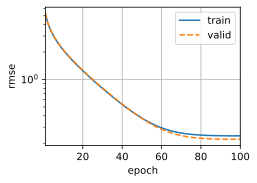

In [34]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')
